In [1]:
import pandas as pd
import numpy as np
import os
%matplotlib notebook 
import matplotlib.pyplot as plt 
os.chdir('C:\\Users\\Sanata\\Dropbox\\01A_Data Science Project')
pd.options.display.max_rows = 50

# Visualization and Analysis of Congress House Member Data 

I obtained data on every member of the House from 1999-2017 from the ProPublica Congress API (the code for scraping the data and constructing the dataset is in another script in this folder). In this notebook, I explore the characteristics of House members over time and by party (Democrat and Republican). Using the results of the exploratory analysis, I then use the member data to build a logistic regression model that predicts when a House member will lose their seat. My model can predict whether a House member is in their last term with an accuracy rate of 0.87, without any information on past vote shares or public opinion polling.  

In [2]:
data = pd.read_pickle('congress_members_pickle')
data.head()

,api_uri,at_large,cong_num,contact_form,crp_id,cspan_id,date_of_birth,district,dw_nominate,facebook_account,...,youtube_account,start_date,age,last_term,pres_party,midterm_yr,spec_elect,start_yr,leadership_bin,pres_party_match
0,https://api.propublica.org/congress/v1/members...,False,106,None,None,None,1938-06-26,1,NaN,None,...,hawaiirep1,1999-01-01,61.0,0.0,D,1,0,1999,0,True
1,https://api.propublica.org/congress/v1/members...,False,106,None,None,1002061,1942-11-19,5,NaN,None,...,RepAckerman,1999-01-01,56.0,0.0,D,1,0,1999,0,True
2,https://api.propublica.org/congress/v1/members...,False,106,None,N00003028,45516,1965-07-22,4,NaN,RobertAderholt,...,RobertAderholt,1999-01-01,33.0,0.0,D,1,0,1999,0,False
3,https://api.propublica.org/congress/v1/members...,False,106,None,None,None,1945-04-16,1,NaN,None,...,None,1999-01-01,54.0,0.0,D,1,0,1999,0,True
4,https://api.propublica.org/congress/v1/members...,False,106,None,None,19670,1957-08-04,1,NaN,None,...,None,1999-01-01,41.0,0.0,D,1,0,1999,0,True


# Descriptive Analysis

The dataset contains over 4,000 observations of House members over 10 sessions, or 20 years. As you can see below, the total number of representatives per session is greater than 435 because the count includes those who replaced sitting members via special elections. 

In [3]:
#number of reps by year 
data.groupby('cong_num').size() #includes special elections

cong_num
106    440
107    443
108    441
109    441
110    448
111    446
112    445
113    444
114    442
115    448
dtype: int64

Members of the current House session (115th) are on average 58 years old, with an steadily increasing average age over the past 20 years. Democrats are on average older than Republicans: in 2017, they were four years older. 

In [4]:
#average age 
data.groupby('start_yr')['age'].mean()

start_yr
1999    53.106818
2001    53.781038
2003    54.487528
2005    55.571429
2007    56.216518
2009    56.724215
2011    56.692135
2013    56.745495
2015    57.176471
2017    57.968750
Name: age, dtype: float64

In [5]:
#average age by party 
data.pivot_table('age', index='start_yr',
                        columns='party', aggfunc='mean')



party,D,I,R
start_yr,,,
1999,53.530516,54.5,52.693333
2001,54.525822,56.5,53.061404
2003,55.211538,61.0,53.810345
2005,56.509804,63.0,54.728814
2007,56.838843,NaN,55.485437
2009,57.501901,NaN,55.606557
2011,59.645000,NaN,54.281633
2013,59.122549,NaN,54.725000
2015,60.057895,NaN,55.003968


One aspect that might explain the age gap between parties is that Democrat House members are  more senior. The average Democrat has been in the House 13 years, versus 9.6 for Republicans. We can see the divergence begin in the 2011 congress, right after the 'red wave' midterm elections of 2010 that ushered in new, younger Tea Party activists. It will be interesting to see whether the same patterns play out after the Democrats' 'blue wave' of 2018. 

In [6]:
#avg yrs in office
data.pivot_table('seniority', index='start_yr',
                            columns='party', aggfunc='mean')



party,D,I,R
start_yr,,,
1999,10.751174,7.0,10.133333
2001,11.708920,9.0,10.438596
2003,12.048077,14.0,10.560345
2005,13.039216,16.0,11.144068
2007,12.198347,NaN,11.728155
2009,12.425856,NaN,11.573770
2011,14.290000,NaN,9.297959
2013,12.666667,NaN,9.475000
2015,13.031579,NaN,8.984127


The last 20 years have been marked by Republican dominance in the House, with a brief period of Democratic majoirty in the first two years under Obama. Republicans have been in the majority with wide margins since 2011. 

<IPython.core.display.Javascript object>


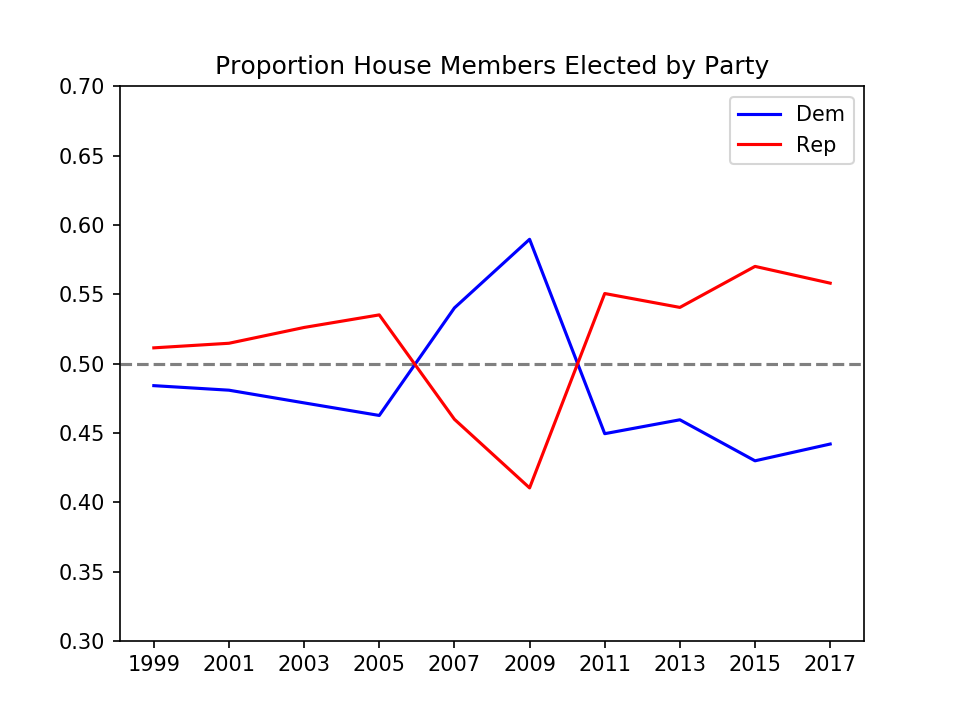

In [7]:
#pct D and R over time 
by_yr = data.groupby('start_yr')
pcounts = by_yr['party'].value_counts().unstack() #data frame 
pprops = pcounts.div(pcounts.sum(axis=1), axis=0)
#Pct dem and rep 
fig = plt.figure() 
ax = fig.add_subplot(111, xticks=data.start_yr.unique().tolist(), ylim=(0.3, 0.7))
ax.axhline(y=0.5, linestyle='--', color='gray')
ax.plot(pprops['D'], 'b', label='Dem')
ax.plot(pprops['R'], 'r', label='Rep')
ax.set_title('Proportion House Members Elected by Party')
ax.legend()

Democrats clearly have shown more progress in getting women elected to the House. While the percentage of Republican women in the House has stagnated at 10 percent, it has steadily risen among Democrats to 30 percent. 

In [8]:
#gender balance over time
g = by_yr['gender'].value_counts().unstack() 
g.div(g.sum(axis=1), axis=0)


gender,F,M
start_yr,,
1999,0.127854,0.872146
2001,0.136054,0.863946
2003,0.136054,0.863946
2005,0.154195,0.845805
2007,0.169643,0.830357
2009,0.170404,0.829596
2011,0.170787,0.829213
2013,0.182432,0.817568
2015,0.192308,0.807692


<IPython.core.display.Javascript object>


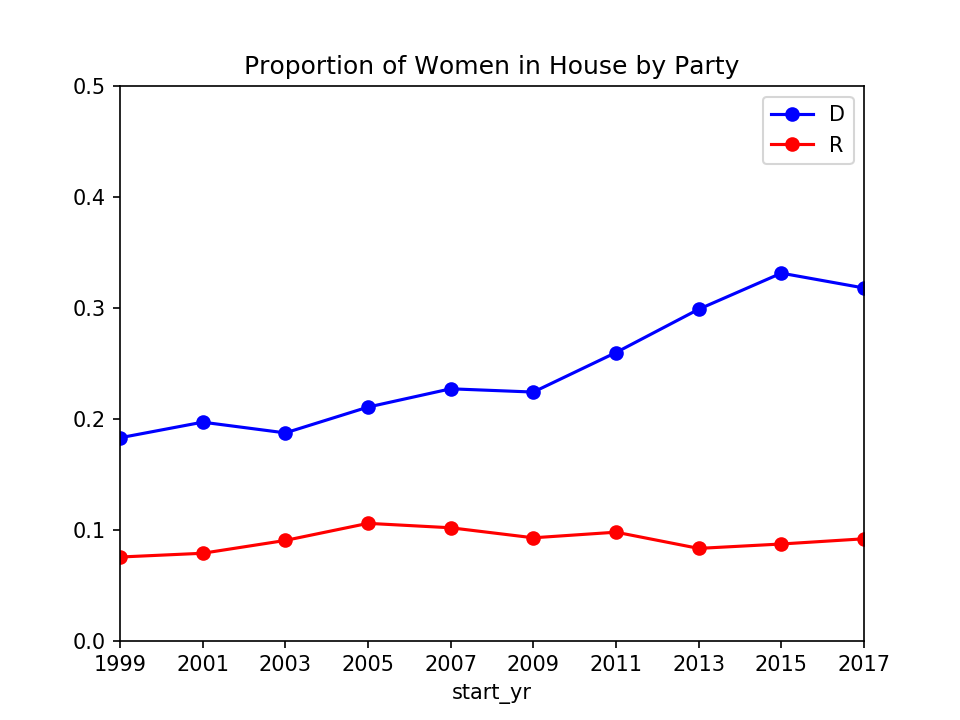

(0, 0.5)

In [9]:
#percent gender by party 
tab = pd.get_dummies(data.gender)
grouped_tab = tab.groupby([data['start_yr'], data['party']]).mean().unstack()
pct_women = grouped_tab.iloc[:, [0, 2]] #select female D and R columns 
pct_women.columns = ['D', 'R']
#plot 
pct_women[['D', 'R']].plot(title='Proportion of Women in House by Party', 
                             color = ['b', 'r'],
                             marker='o')
plt.axes().set_xticks(ticks = data.start_yr.unique().tolist())
plt.ylim([0, 0.5])

Next, I turn to a comparison of House incumbents who were ousted versus those who kept their seats. I denote an ousted incumbent in the dataset if the current term is their last term (that is, their name no longer appears in subsequent member lists). For each Session of Congress, I compare the statistics of those who were ousted (1) to those who were safe (0). Departing members seemed to be a bit older and more senior, especially so in 2013 and 2015. Seniority measures the number of years the member has been in Congress. Note that the 2017 session is dropped because it's the last session. 

In [10]:
#comparing ousted incumbents (those in their last term) versus safe incumbents
#0 = safe, 1 = last term 
#by age 
out = data.groupby(['start_yr', 'last_term'])
out.age.mean().unstack()


last_term,0.0,1.0
start_yr,,
1999,52.783375,56.093023
2001,53.345550,56.508197
2003,54.307305,56.113636
2005,55.293194,57.372881
2007,56.054688,57.187500
2009,56.888252,56.134021
2011,56.464589,57.565217
2013,56.195251,59.953846
2015,56.955959,58.696429


In [11]:
#by seniority 
out.seniority.mean().unstack()

last_term,0.0,1.0
start_yr,,
1999,10.156171,12.837209
2001,10.654450,13.475410
2003,11.193955,11.954545
2005,11.727749,14.000000
2007,11.734375,13.468750
2009,12.297994,11.278351
2011,11.178470,12.934783
2013,10.195251,15.292308
2015,10.606218,11.535714


I then look at differences in party loyalty to see whether voters punish incumbents that do not vote as consistently with their party. I do this using the 'votes with party percentage' variable, which tracks the percentage of time the member voted with his or her party. Overall, we see that over the past 20 years party-line votes have increases from the upper 80s to the lower-mid 90s. Indeed, we do see that ousted members do have lower rates of voting with their party. 

In [12]:
loyalty = out.votes_with_party_pct.mean().unstack() 
loyalty

last_term,0.0,1.0
start_yr,,
1999,88.943275,87.627674
2001,91.030209,90.487869
2003,92.103048,91.967727
2005,91.178141,91.182203
2007,93.078828,89.630938
2009,94.609771,92.437423
2011,91.070198,87.934130
2013,92.710712,89.878462
2015,93.862435,92.286296


<IPython.core.display.Javascript object>


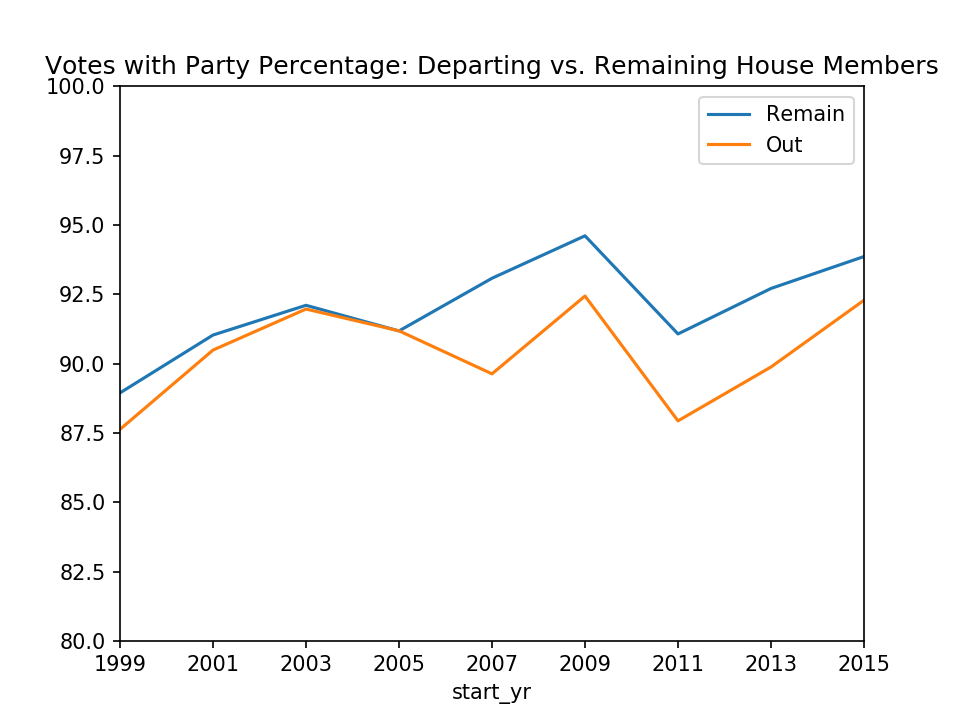

In [13]:
#plot differences in percentage votes with party 
loyalty.plot(title = 'Votes with Party Percentage: Departing vs. Remaining House Members')
plt.axes().set_xticks(ticks = data.start_yr.unique().tolist()[:-1])
plt.ylim([80, 100])
plt.legend(['Remain', 'Out'])


Finally, I looked at the turnover rates for both Democrats and Republicans over time. This includes members who left and were replaced by members of the same or the opposite party, and those who retired or were promoted (I do not have enough information to distinguish between reasons for replacement). We see peak Republican turnover after the 2004 and 2006 elections under Bush, and peak Democrat turnover after the 2008 and 2011 elections under Obama. It seems then that members are most likely to depart in years where they are in the same party as the president. This makes sense in the context of American politics, where voters often elect the opposition party to Congress as a check on the President. 

<IPython.core.display.Javascript object>


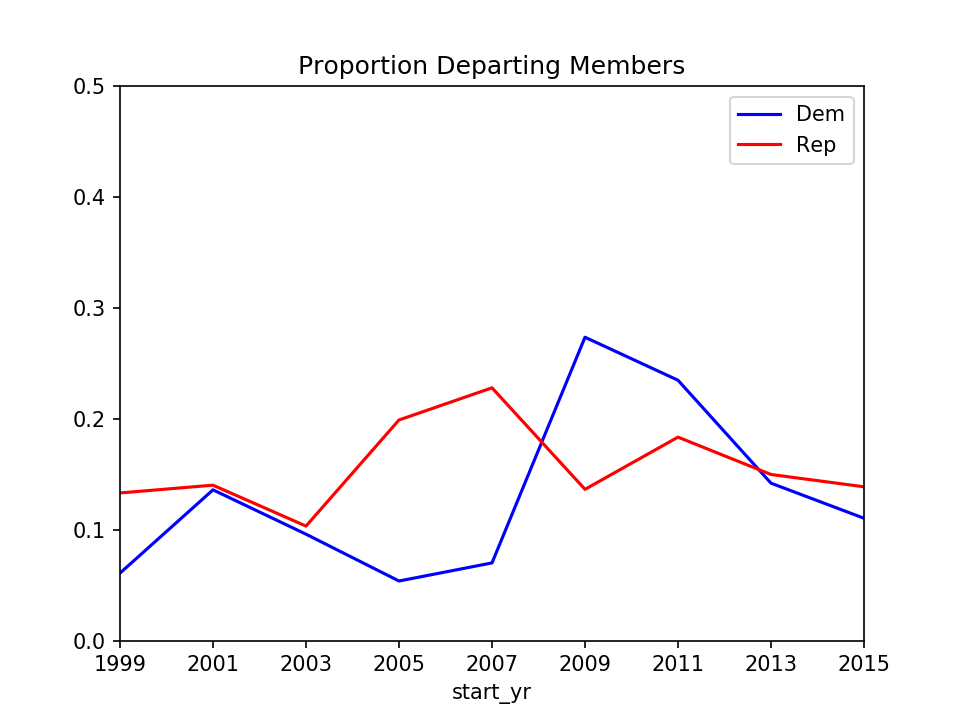

In [14]:
#rates of replacement by party 
raw = out.party.value_counts().unstack()
replace_rates = pd.DataFrame({'p_out_dem': raw.D / raw.groupby(['start_yr'])['D'].sum(), 
                              'p_out_rep': raw.R / raw.groupby(['start_yr'])['R'].sum()})
replace_rates.reset_index(level=1, inplace=True)
rates = replace_rates[replace_rates.last_term==1]

#plot 
rates[['p_out_dem', 'p_out_rep']].plot(title = 'Proportion Departing Members', 
                                  color = ['b', 'r'])
plt.ylim([0, 0.5])
plt.legend(['Dem', 'Rep'])
plt.axes().set_xticks(ticks = data.start_yr.unique().tolist()[:-1])


# Classification Problem 

Given what we know about trends in the composition of the House over time, can we predict when a member of Congress is in their last term? I model this as a binary classification problem, where we assign each member observation to a 'leave' or 'stay' class. I therefore selected a logistic regression with 'last term' as my binary target variable. Some of the features I consider are the member's votes with party, seniority, and a party ID match with the President. 

In [15]:
#Construct the dataset 

#columns to keep 
cols_to_keep = ['start_yr',  'age', 'votes_with_party_pct', 'seniority',
                'leadership_bin', 'midterm_yr', 'pres_party_match','last_term']
dat_sub = data[cols_to_keep]
#add dummies 
to_dummies = pd.get_dummies(data[['gender', 'party','pres_party']])
dat = dat_sub.join(to_dummies)
#final data frame 
dat.dropna(inplace=True)

Below I split the data into a training and validation set, build and fit a logistic regression model, and calculate the accuracy. On average my model is expected to correctly predict the status of a House member as 'last term' 87% of the time. 

In [16]:
#Build the model 

#split the data 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dat.loc[:, dat.columns != 'last_term'], dat.last_term, test_size=0.25, random_state=0)

#run regression
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression(C=10)
logfit = logisticRegr.fit(X_train, y_train)

#get accuracy 
train_accuracy = logfit.score(X_train, y_train) 
test_accuracy = logfit.score(X_test, y_test) 

print("Training set score: {:.2f}".format(train_accuracy))
print("Test set score: {:.2f}".format(test_accuracy))



Training set score: 0.85
Test set score: 0.87


I then plot the coefficients of my logistic regression model to get a sense of which features contribute most to raising or lowering the odds that a House member will be in their last term. From the plot, it seems that being in a midterm year, being a Democrat, and being under a Republican president lowers the chances of losing your seat in a given session. Having a party match with the President, being a Republican, and being under a Democratic president raises the chances of losing your seat. 

<IPython.core.display.Javascript object>


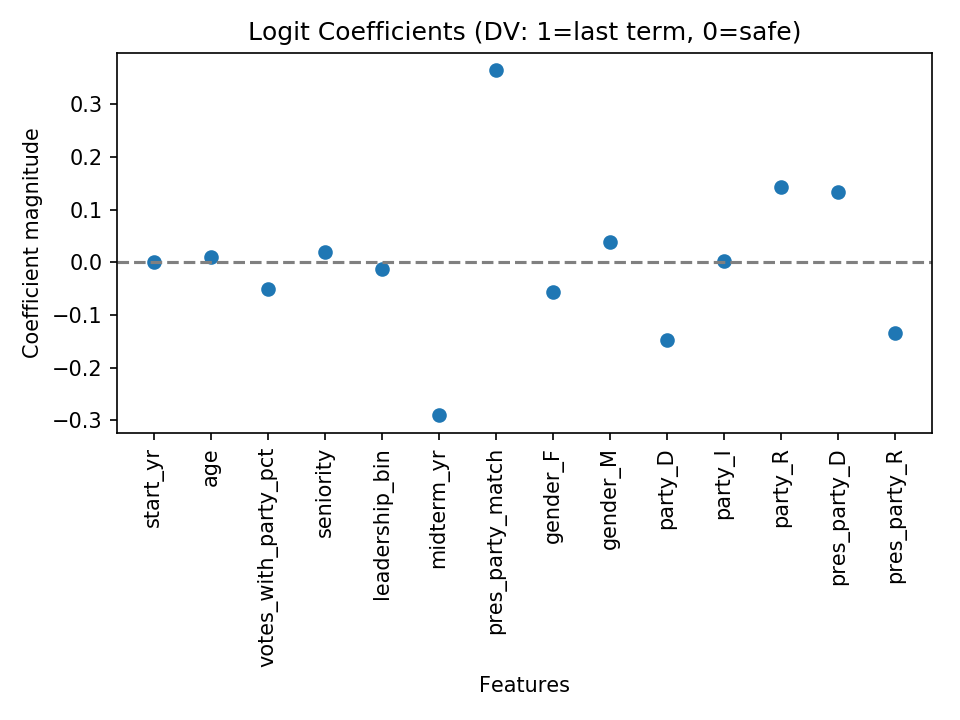

In [17]:
#plot coefficients 
fig = plt.figure() 
ax = fig.add_subplot(111, xticks=range(dat.shape[1]))
ax.plot(logfit.coef_.T, 'o')
ax.axhline(y=0, linestyle='--', color='gray')
ax.set_xticklabels(X_train.columns, rotation=90)
ax.set_xlabel("Features")
ax.set_ylabel("Coefficient magnitude")
ax.set_title('Logit Coefficients (DV: 1=last term, 0=safe)')
plt.tight_layout()




To further improve the accuracy of my model, and with more time, I would add an indicator for whether the House member is in a swing state or a solidly red or blue state, perhaps using the most recent presidential election returns prior to the Congressional session. I could also model the problem as a hazard model, where the risk is losing a seat in any given year. 